In [ ]:
# librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import inspect
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector

#librerias modelos
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# librerias validacion
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Base de datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga de datos
Obligaciones_clientes=pd.read_excel('/content/drive/MyDrive/Prueba/Obligaciones_clientes.xlsx')
Tasas_productos= pd.read_excel('/content/drive/MyDrive/Prueba/tasas_productos.xlsx')
Tasas_obligaciones = pd.read_excel('/content/drive/MyDrive/Prueba/tasas_obligaciones.xlsx')
Deuda_clientes = pd.read_excel('/content/drive/MyDrive/Prueba/Deuda_clientes.xlsx')

In [ ]:
df= Tasas_obligaciones.merge(Deuda_clientes, left_on='num_documento', right_on='num_documento')

In [ ]:
#Identificación valores duplicados
df1 = df[df.duplicated(keep=False)]

df1 = df1.groupby(df1.columns.tolist()).apply(lambda x: x.index.tolist()).values.tolist()
df1= np.array(df1)
filtered_df=df.iloc[df1.flatten()]
filtered_df

radicado  num_documento  cod_segm_tasa  cod_subsegm_tasa  \
248  14427613335     1080618793              5                 4   
271  14427613335     1080618793              5                 4   

    cal_interna_tasa                                     id_producto  \
248               C2  0000000000200021991 - 22-Leasing Cartera Total   
271               C2  0000000000200021991 - 22-Leasing Cartera Total   

          tipo_id_producto  valor_inicial fecha_desembolso  plazo  ...  \
248  Obligacion - producto        90660.0       2021-08-31   48.0  ...   
271  Obligacion - producto        90660.0       2021-08-31   48.0  ...   

     tasa_operacion_especifica tasa_hipotecario  tasa_leasing tasa_sufi  \
248                   0.171569         0.121946      0.108922   0.08889   
271                   0.171569         0.121946      0.108922   0.08889   

    tasa_factoring  tasa_tarjeta tasa_producto  tasa_efectiva  \
248       0.144165        0.3867      0.164156       0.012747   
271       0.144165        0.3867      0.164156       0.012747   

    valor_inicial_te   total_deuda  
248      1155.634471  1.463795e+07  
271      1155.634471  1.463795e+07  

[2 rows x 30 columns]

In [ ]:
#Se eliminan valores duplicados
df=df.drop_duplicates()

In [ ]:
#Revisión de datos nulos
print(df.isna().sum())

radicado                     0
num_documento                0
cod_segm_tasa                0
cod_subsegm_tasa             0
cal_interna_tasa             0
id_producto                  0
tipo_id_producto             0
valor_inicial                0
fecha_desembolso             0
plazo                        6
cod_periodicidad             0
periodicidad                 0
saldo_deuda                  0
modalidad                    0
tipo_plazo                   0
cod_segmento                 0
segmento                     0
cod_subsegmento              0
calificacion_riesgos         0
tasa_cartera                 0
tasa_operacion_especifica    0
tasa_hipotecario             0
tasa_leasing                 0
tasa_sufi                    0
tasa_factoring               0
tasa_tarjeta                 0
tasa_producto                0
tasa_efectiva                0
valor_inicial_te             0
total_deuda                  0
dtype: int64


In [ ]:
#Se cambian tipo de datos
df = df.astype({'radicado': 'object', 'num_documento': 'object'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2047
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   radicado                   2047 non-null   object        
 1   num_documento              2047 non-null   object        
 2   cod_segm_tasa              2047 non-null   int64         
 3   cod_subsegm_tasa           2047 non-null   int64         
 4   cal_interna_tasa           2047 non-null   object        
 5   id_producto                2047 non-null   object        
 6   tipo_id_producto           2047 non-null   object        
 7   valor_inicial              2047 non-null   float64       
 8   fecha_desembolso           2047 non-null   datetime64[ns]
 9   plazo                      2041 non-null   float64       
 10  cod_periodicidad           2047 non-null   int64         
 11  periodicidad               2047 non-null   object        
 12  saldo_

In [ ]:
def calcularMontoDeudaSegmento(df):
  result = df[['segmento','saldo_deuda']]
  return result.groupby('segmento').sum('saldo_deuda')

calcularMontoDeudaSegmento(df)

saldo_deuda
segmento                               
Empresarial                1.494533e+08
NEGOCIOS E INDEPENDIENTES  3.417053e+06
PYME                       3.513552e+08

**Visualizaciones**

<Axes: xlabel='count', ylabel='calificacion_riesgos'>

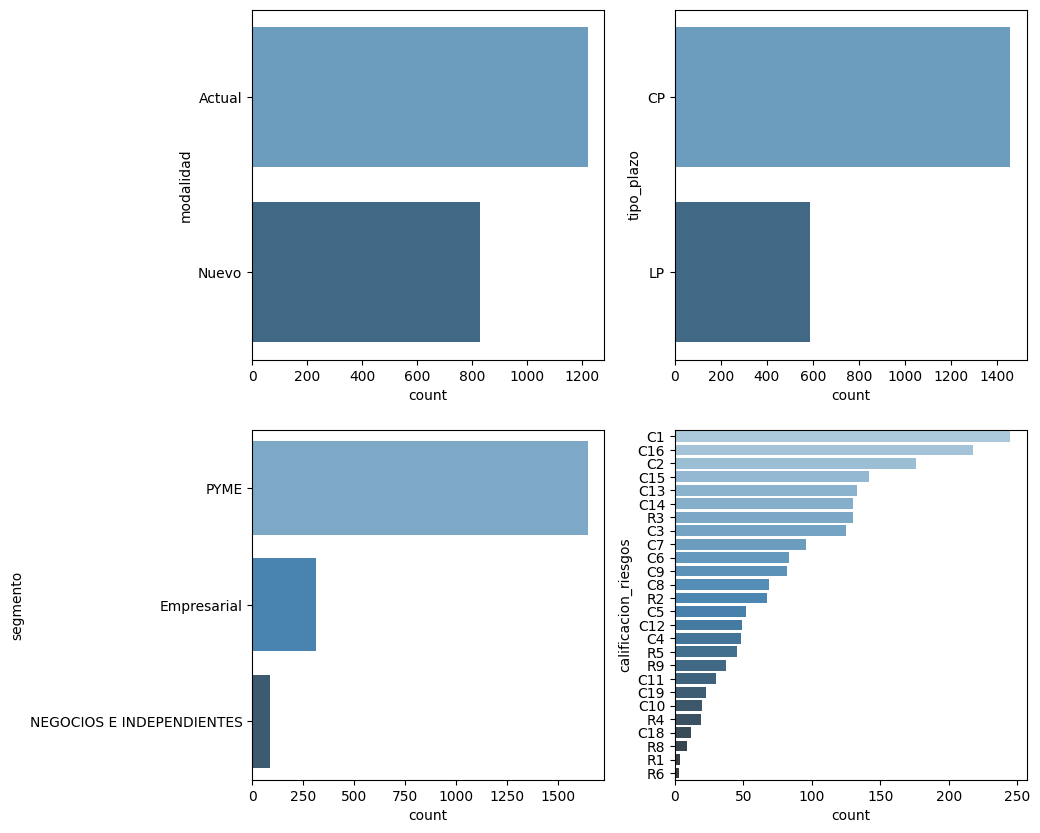

In [ ]:
# Diagramas de barras para Variables cualitativas mas relevantes
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
sns.countplot(y="modalidad",
    data=df,
    order=df['modalidad'].value_counts().index,
    palette="Blues_d",
    linewidth=3)
plt.subplot(2,2,2)
sns.countplot(y="tipo_plazo",
    data=df,
    order=df['tipo_plazo'].value_counts().index,
    palette="Blues_d",
    linewidth=3)
plt.subplot(2,2,3)
sns.countplot(y="segmento",
    data=df,
    order=df['segmento'].value_counts().index,
    palette="Blues_d",
    linewidth=3)
plt.subplot(2,2,4)
sns.countplot(y="calificacion_riesgos",
    data=df,
    order=df['calificacion_riesgos'].value_counts().index,
    palette="Blues_d",
    linewidth=3)

Text(0.5, 1.0, 'Deuda total por anio')

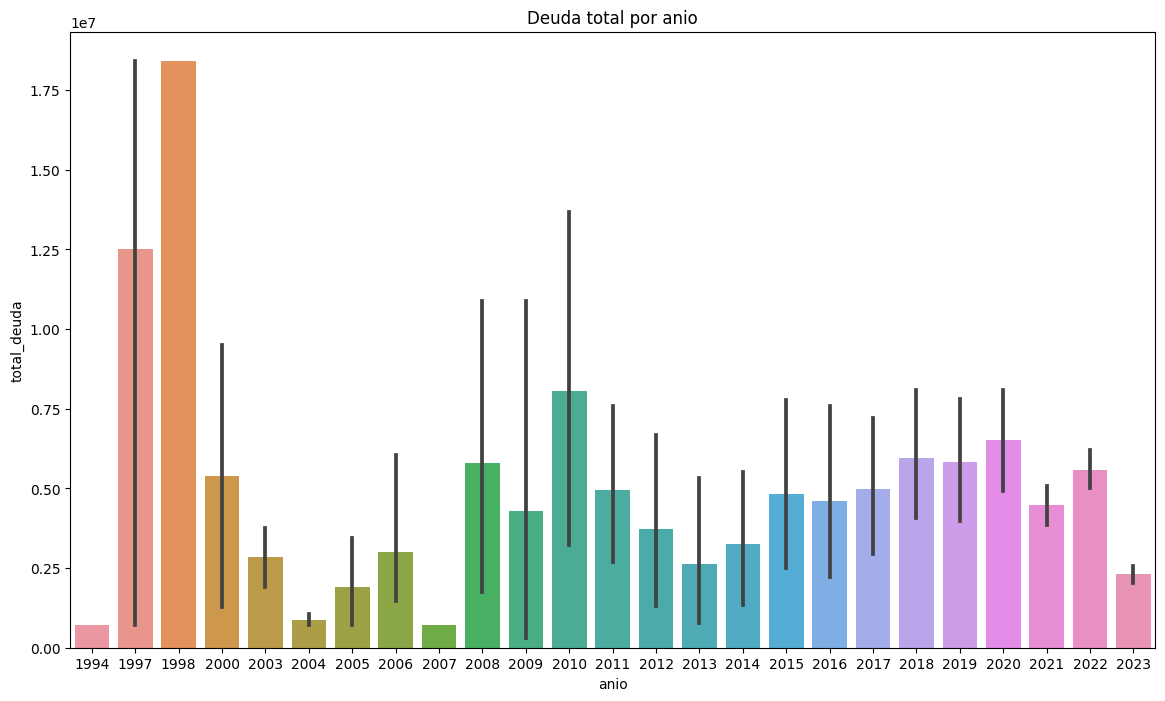

In [ ]:
#Cambio de la deuda en el tiempo
df['anio'] = pd.to_datetime(df['fecha_desembolso']).dt.year

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x = "anio", y = "total_deuda", data = df)
plt.title('Deuda total por anio')

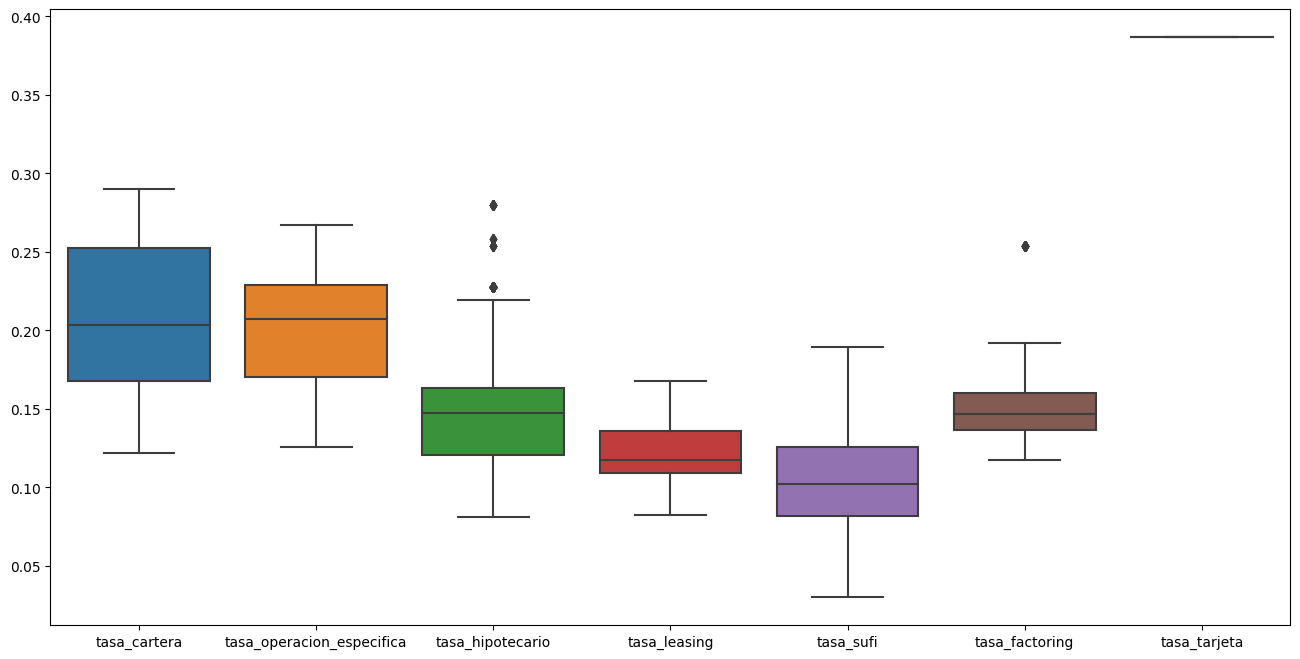

In [ ]:
#Se generan gráficos boxplot por grupos de variables
df_plot1= df[['tasa_cartera', 'tasa_operacion_especifica', 'tasa_hipotecario', 'tasa_leasing', 'tasa_sufi', 'tasa_factoring', 'tasa_tarjeta']]
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_plot1)
plt.show()

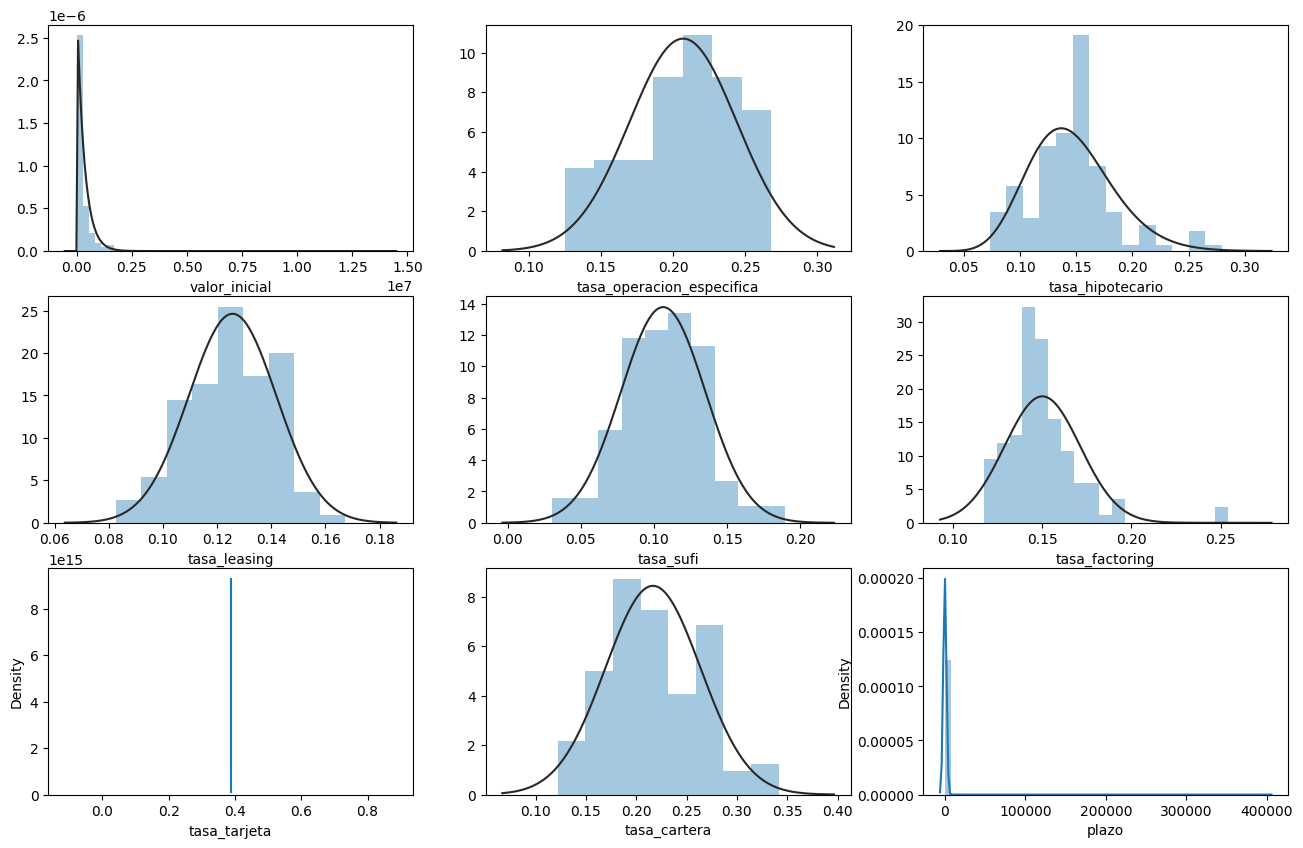

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
plt.subplot(3,3,1)
sns.distplot(df['valor_inicial'], kde = False, fit = stats.expon)
plt.subplot(3,3,2)
sns.distplot(Tasas_productos['tasa_operacion_especifica'], kde = False, fit = stats.norm)
plt.subplot(3,3,3)
sns.distplot(Tasas_productos['tasa_hipotecario'], kde = False, fit = stats.gamma)
plt.subplot(3,3,4)
sns.distplot(Tasas_productos['tasa_leasing'], kde = False, fit = stats.norm)
plt.subplot(3,3,5)
sns.distplot(Tasas_productos['tasa_sufi'], kde = False, fit = stats.norm)
plt.subplot(3,3,6)
sns.distplot(Tasas_productos['tasa_factoring'], kde = False, fit = stats.norm)
plt.subplot(3,3,7)
sns.distplot(Tasas_productos['tasa_tarjeta'])
plt.subplot(3,3,8)
sns.distplot(Tasas_productos['tasa_cartera'], kde = False, fit = stats.norm)
plt.subplot(3,3,9)
sns.distplot(df['plazo'])
plt.show()

In [ ]:
#Distribuciones por segmento
df3= df[['segmento', 'plazo', 'tasa_cartera', 'tasa_operacion_especifica', 'tasa_hipotecario', 'tasa_leasing', 'tasa_sufi', 'tasa_factoring', 'tasa_tarjeta']]

pyme= df3['segmento']== 'PYME'
df_pyme= df3.loc[pyme,:]

Emp= df3['segmento']== 'Empresarial'
df_Emp= df3.loc[Emp,:]

Neg= df3['segmento']== 'NEGOCIOS E INDEPENDIENTES'
df_Neg= df3.loc[Neg,:]

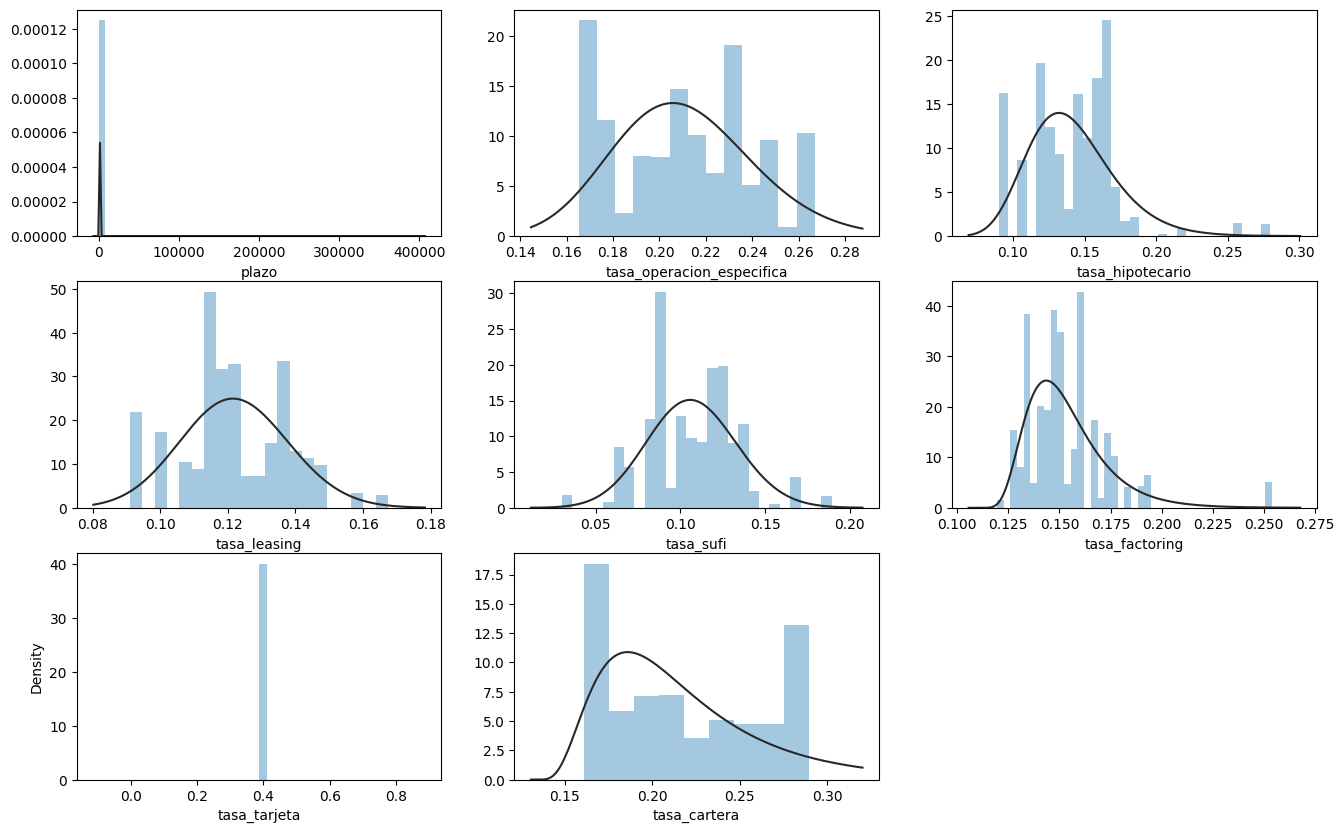

In [ ]:
#PYME
fig, ax = plt.subplots(figsize=(16,10))
plt.subplot(3,3,1)
sns.distplot(df_pyme['plazo'], kde = False, fit = stats.expon)
plt.subplot(3,3,2)
sns.distplot(df_pyme['tasa_operacion_especifica'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,3)
sns.distplot(df_pyme['tasa_hipotecario'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,4)
sns.distplot(df_pyme['tasa_leasing'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,5)
sns.distplot(df_pyme['tasa_sufi'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,6)
sns.distplot(df_pyme['tasa_factoring'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,7)
sns.distplot(df_pyme['tasa_tarjeta'])
plt.subplot(3,3,8)
sns.distplot(df_pyme['tasa_cartera'], kde = False, fit = stats.lognorm)

plt.show()

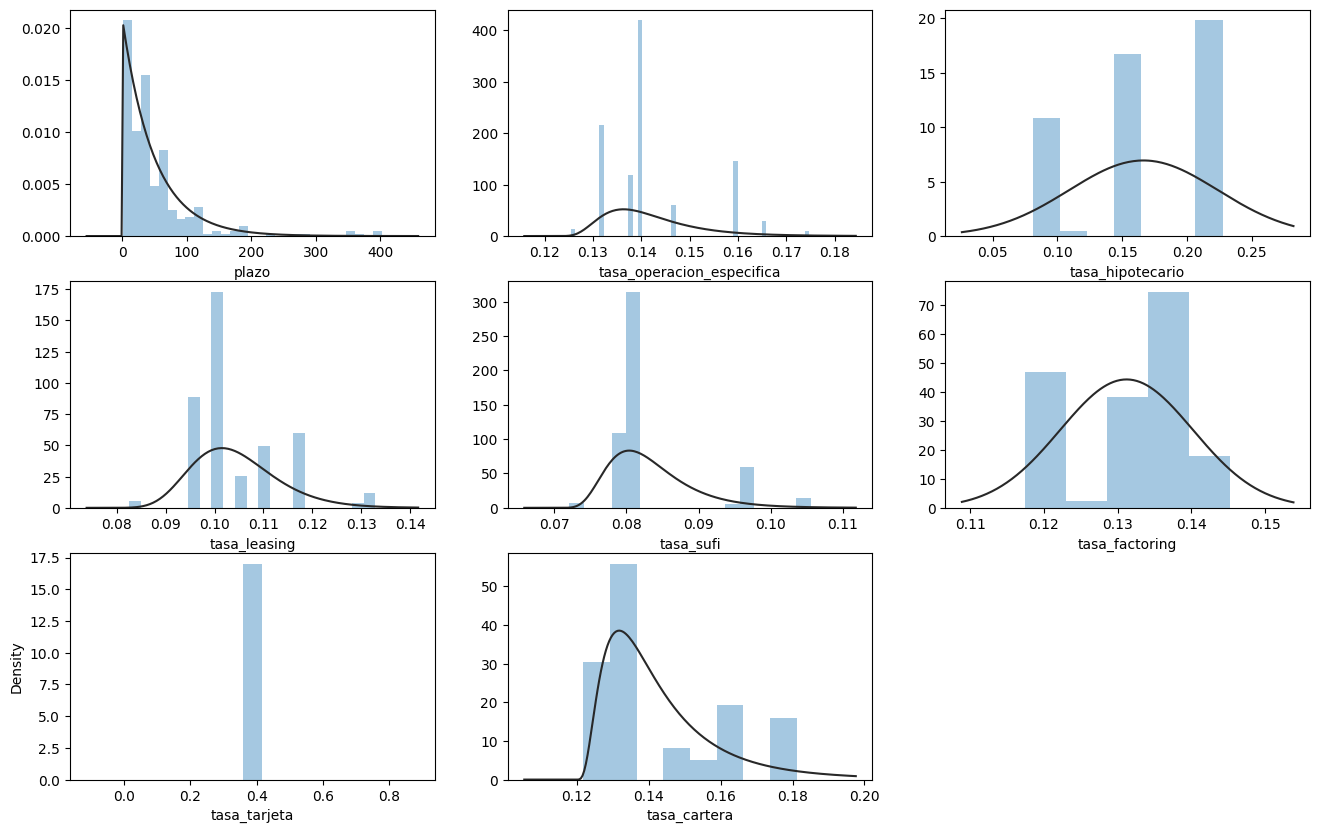

In [ ]:
#Empresarial
fig, ax = plt.subplots(figsize=(16,10))
plt.subplot(3,3,1)
sns.distplot(df_Emp['plazo'], kde = False, fit = stats.expon)
plt.subplot(3,3,2)
sns.distplot(df_Emp['tasa_operacion_especifica'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,3)
sns.distplot(df_Emp['tasa_hipotecario'], kde = False, fit = stats.norm)
plt.subplot(3,3,4)
sns.distplot(df_Emp['tasa_leasing'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,5)
sns.distplot(df_Emp['tasa_sufi'], kde = False, fit = stats.lognorm)
plt.subplot(3,3,6)
sns.distplot(df_Emp['tasa_factoring'], kde = False, fit = stats.norm)
plt.subplot(3,3,7)
sns.distplot(df_Emp['tasa_tarjeta'])
plt.subplot(3,3,8)
sns.distplot(df_Emp['tasa_cartera'], kde = False, fit = stats.lognorm)

plt.show()

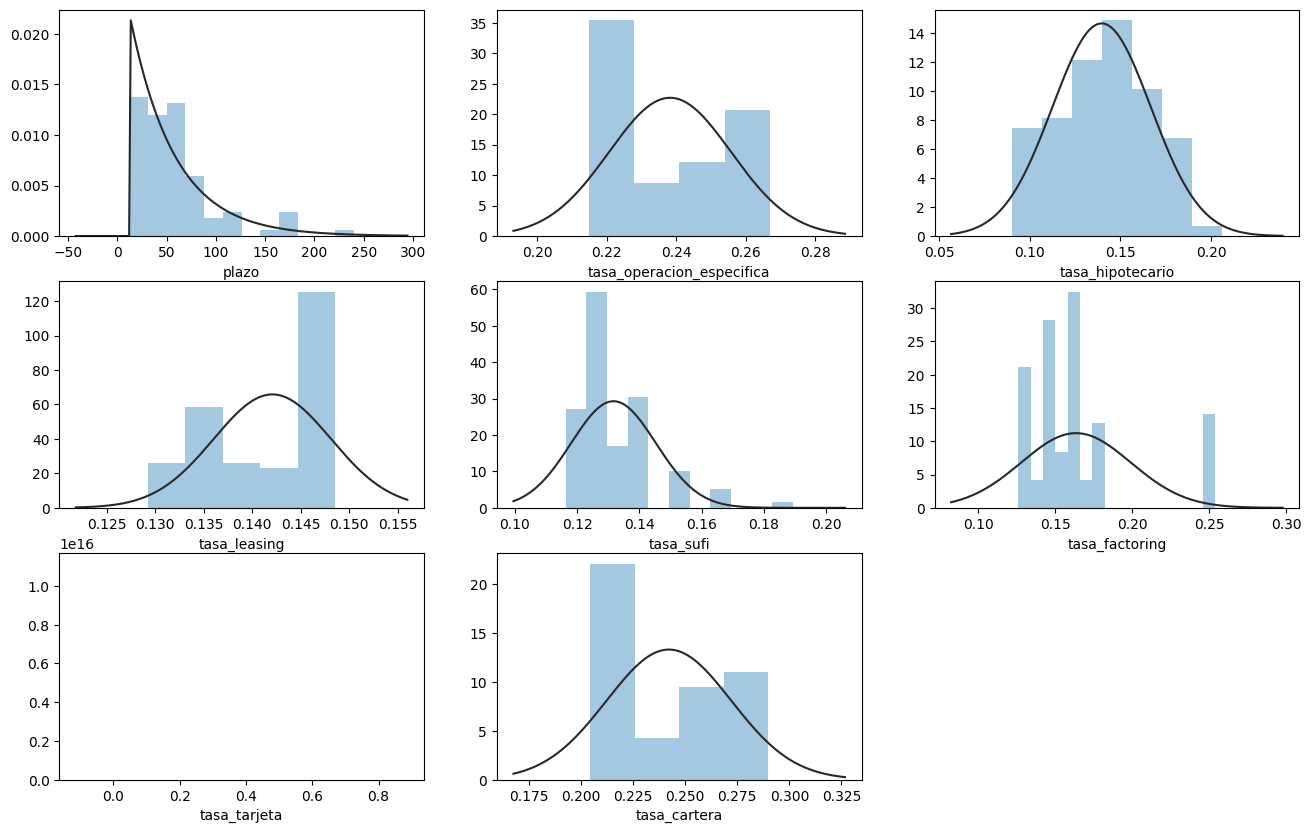

In [ ]:
#Negocios
fig, ax = plt.subplots(figsize=(16,10))
plt.subplot(3,3,1)
sns.distplot(df_Neg['plazo'], kde = False, fit = stats.expon)
plt.subplot(3,3,2)
sns.distplot(df_Neg['tasa_operacion_especifica'], kde = False, fit = stats.norm)
plt.subplot(3,3,3)
sns.distplot(df_Neg['tasa_hipotecario'], kde = False, fit = stats.norm)
plt.subplot(3,3,4)
sns.distplot(df_Neg['tasa_leasing'], kde = False, fit = stats.norm)
plt.subplot(3,3,5)
sns.distplot(df_Neg['tasa_sufi'], kde = False, fit = stats.norm)
plt.subplot(3,3,6)
sns.distplot(df_Neg['tasa_factoring'], kde = False, fit = stats.norm)
plt.subplot(3,3,7)
sns.distplot(df_Neg['tasa_tarjeta'], kde = False, fit = stats.beta)
plt.subplot(3,3,8)
sns.distplot(df_Neg['tasa_cartera'], kde = False, fit = stats.norm)

plt.show()

<Axes: >

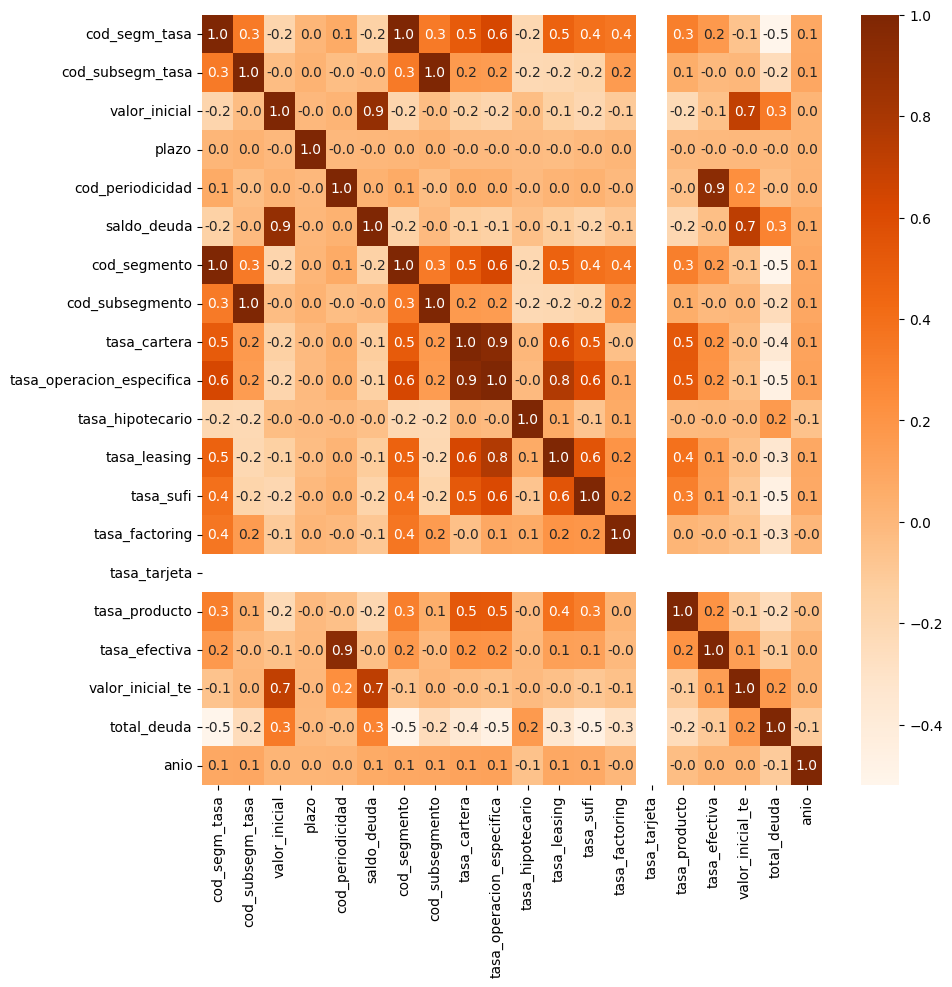

In [ ]:
#Diagrama correlación entre variables cuantitativas
corr=df.corr()
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, cmap = 'Oranges', annot = True, fmt=".1f", ax = ax)

**Preprocesamiento**

Realizaremos una transformación de las variables categoricas y escalamiento de las númericas para tener un modelo de predicción mas acertado.

In [ ]:
#Se eliminan variables no requeridas para el análisis
df2= df.drop(columns=['radicado', 'num_documento', 'tipo_id_producto', 'id_producto', 'periodicidad', 'cal_interna_tasa', 'segmento', 'fecha_desembolso'], axis=1)

In [ ]:
#Se homologan y cambian algunos valores
df2= df2.replace({"Actual": 0, "Nuevo": 1})

In [ ]:
# crear un selector numérico
num_selector = make_column_selector(dtype_include='number')
# Instanciar transformadores
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# Instanciar pipelines
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)

In [ ]:
# División de valores
X = df2.drop(columns=['saldo_deuda'], axis=1)
y = df2['saldo_deuda']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Selector categórico
cat_selector = make_column_selector(dtype_include='object')
cat_selector(X_train)

['tipo_plazo', 'calificacion_riesgos']

In [ ]:
#Realizar una codificación one-hot cualquier característica nominal

# crear un subconjunto de datos solo para las columnas categóricas
train_cat_data = X_train[cat_selector(X_train)]
test_cat_data = X_test[cat_selector(X_test)]
train_cat_data

tipo_plazo calificacion_riesgos
274          CP                   C2
1912         LP                  C16
250          CP                   C2
414          LP                   C2
1337         CP                   C2
...         ...                  ...
1131         LP                  C16
1295         LP                   R5
861          CP                  C19
1460         LP                  C14
1127         LP                   R6

[1535 rows x 2 columns]

In [ ]:
# instanciar la codificación one-hot
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# ajustar el OneHotEncoder en los datos de entrenamiento
ohe_encoder.fit(train_cat_data)
# transformar los datos de entrenamiento y de prueba
train_ohe = ohe_encoder.transform(train_cat_data)
test_ohe = ohe_encoder.transform(test_cat_data)
train_ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [ ]:
# convertir DataFrame
ohe_column_names = ohe_encoder.get_feature_names_out(train_cat_data.columns)
train_ohe = pd.DataFrame(train_ohe, columns=ohe_column_names)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_column_names)
train_ohe

tipo_plazo_CP  tipo_plazo_LP  calificacion_riesgos_C1  \
0               1.0            0.0                      0.0   
1               0.0            1.0                      0.0   
2               1.0            0.0                      0.0   
3               0.0            1.0                      0.0   
4               1.0            0.0                      0.0   
...             ...            ...                      ...   
1530            0.0            1.0                      0.0   
1531            0.0            1.0                      0.0   
1532            1.0            0.0                      0.0   
1533            0.0            1.0                      0.0   
1534            0.0            1.0                      0.0   

      calificacion_riesgos_C10  calificacion_riesgos_C11  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1530                       0.0                       0.0   
1531                       0.0                       0.0   
1532                       0.0                       0.0   
1533                       0.0                       0.0   
1534                       0.0                       0.0   

      calificacion_riesgos_C12  calificacion_riesgos_C13  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1530                       0.0                       0.0   
1531                       0.0                       0.0   
1532                       0.0                       0.0   
1533                       0.0                       0.0   
1534                       0.0                       0.0   

      calificacion_riesgos_C14  calificacion_riesgos_C15  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1530                       0.0                       0.0   
1531                       0.0                       0.0   
1532                       0.0                       0.0   
1533                       1.0                       0.0   
1534                       0.0                       0.0   

      calificacion_riesgos_C16  ...  calificacion_riesgos_C8  \
0                          0.0  ...                      0.0   
1                          1.0  ...                      0.0   
2                          0.0  ...                      0.0   
3                          0.0  ...                      0.0   
4                          0.0  ...                      0.0   
...                        ...  ...                      ...   
1530                       1.0  ...                      0.0   
1531                       0.0  ...                      0.0   
1532                       0.0  ...                      0.0   
1533                       0.0  ...                      0.0   
1534                       0.0  ...                      0.0   

      calificacion_riesgos_C9  calificacion_riesgos_R1  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0

In [ ]:
#Instanciar transformador de columnas numpericas

# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple)

In [ ]:
#Transformar datos
# columnas numéricas
train_nums_data = X_train[num_selector(X_train)].reset_index(drop=True)
test_nums_data = X_test[num_selector(X_test)].reset_index(drop=True)

# fit on train
preprocessor.fit(train_nums_data)

train_nums = preprocessor.transform(train_nums_data)
test_nums = preprocessor.transform(test_nums_data)

In [ ]:
#Concatenar todas las características de vuelta a un DataFrame.
train_nums = pd.DataFrame(train_nums, columns= train_nums_data.columns)
test_nums = pd.DataFrame(test_nums, columns= test_nums_data.columns)

In [ ]:
# unir los conjuntos de entrenamiento y de prueba
X_train_processed = pd.concat([train_nums, train_ohe], axis=1)
X_test_processed = pd.concat([test_nums, test_ohe], axis=1)

In [ ]:
#Unir en 1 solo conjunto
X_processed= pd.concat([X_train_processed, X_test_processed])

In [ ]:
df_cor= X_processed.drop(columns=['cod_segm_tasa', 'cod_subsegm_tasa', 'valor_inicial', 'plazo', 'cod_periodicidad', 'modalidad', 'cod_segmento', 'cod_subsegmento',
                                  'tipo_plazo_CP', 'tipo_plazo_LP', 'anio','valor_inicial_te' ], axis=1)

<Axes: >

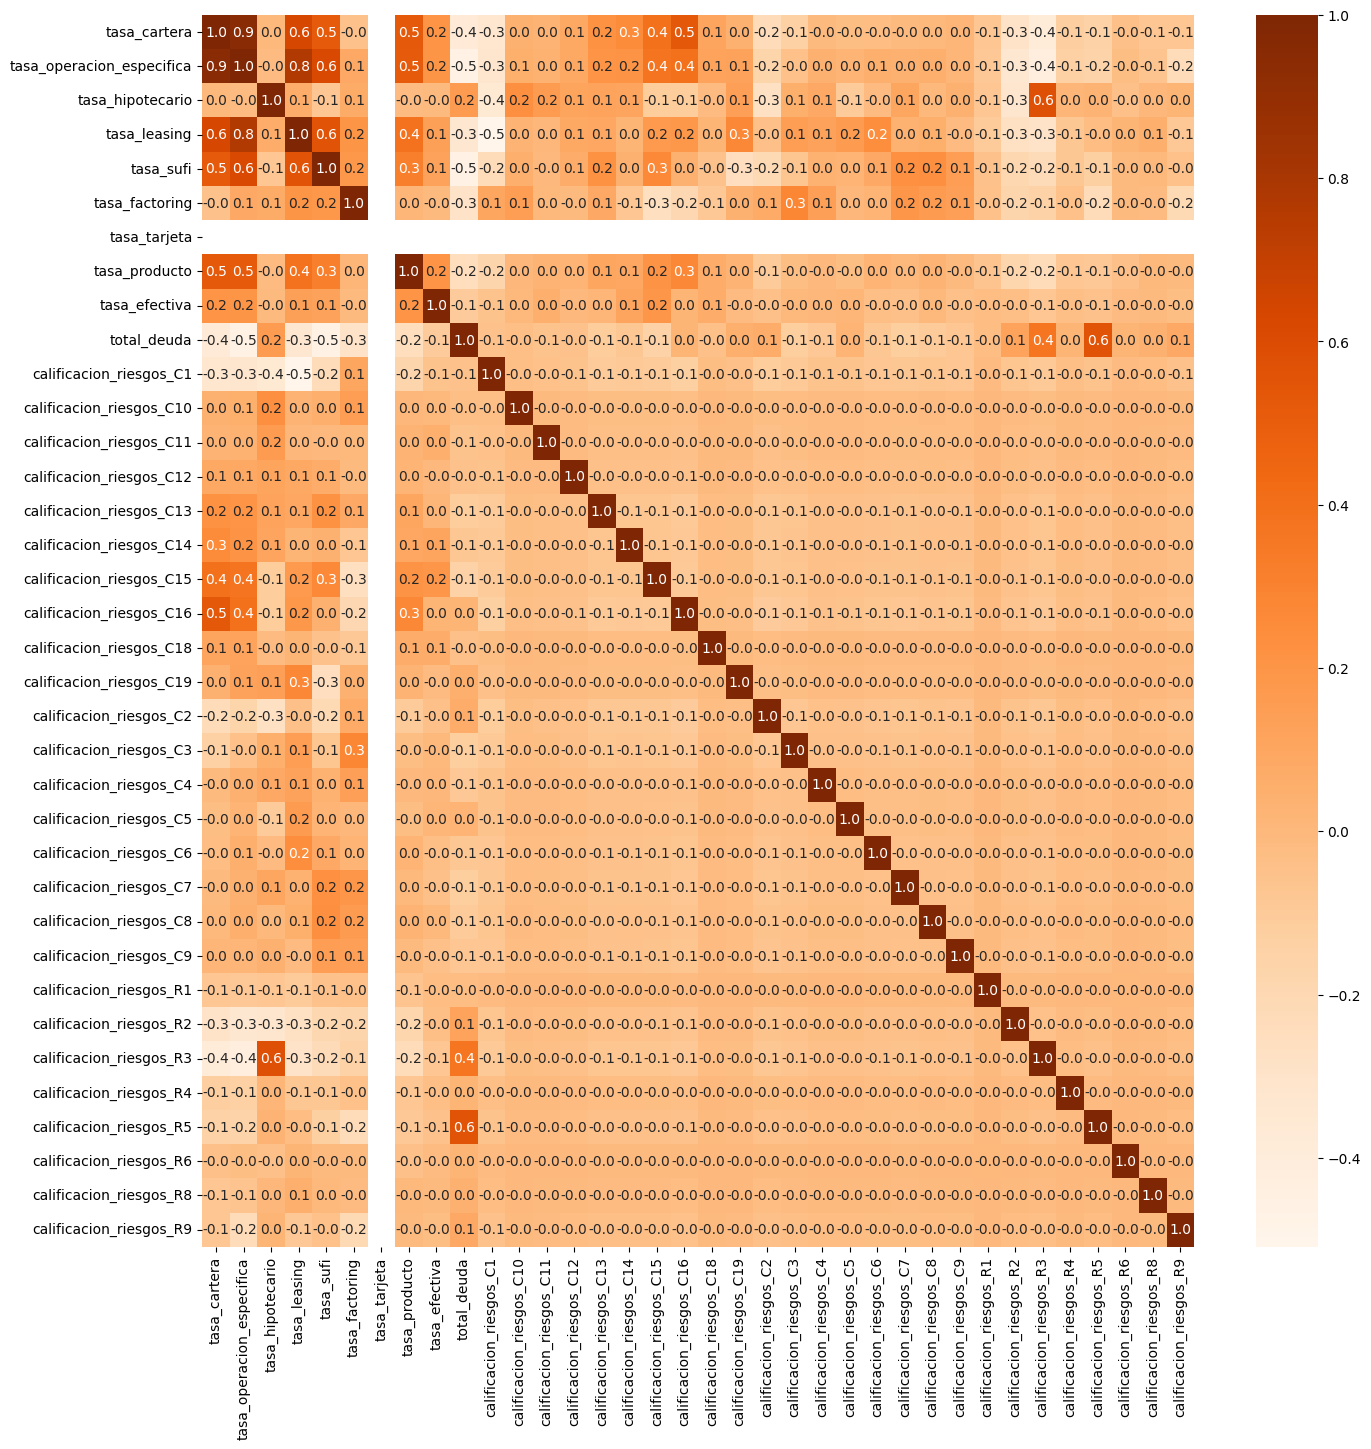

In [ ]:
#Diagrama correlación entre variables luego de transformación
corr=df_cor.corr()
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr, cmap = 'Oranges', annot = True, fmt=".1f", ax = ax)

<Axes: >

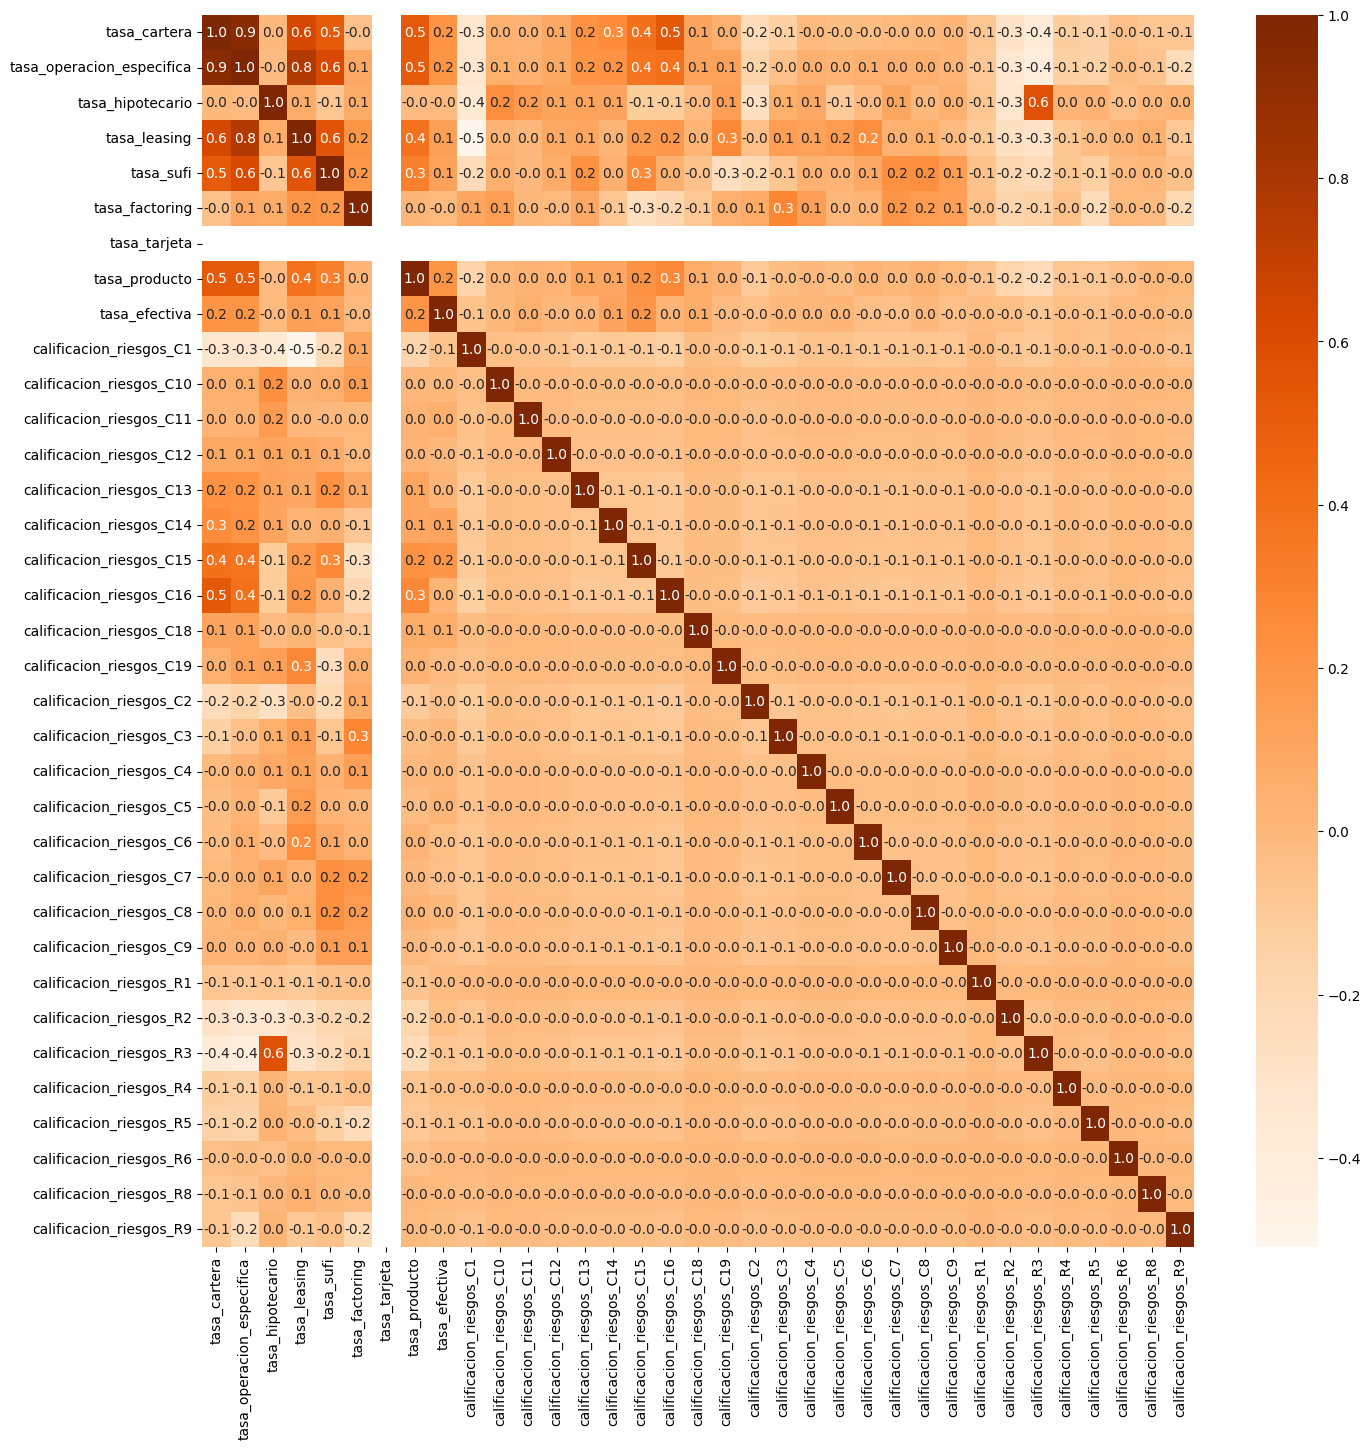

In [ ]:
#Diagrama correlación entre variables luego de transformación
corr=df_cor.corr()
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr, cmap = 'Oranges', annot = True, fmt=".1f", ax = ax)

# Modelos

**k-means**

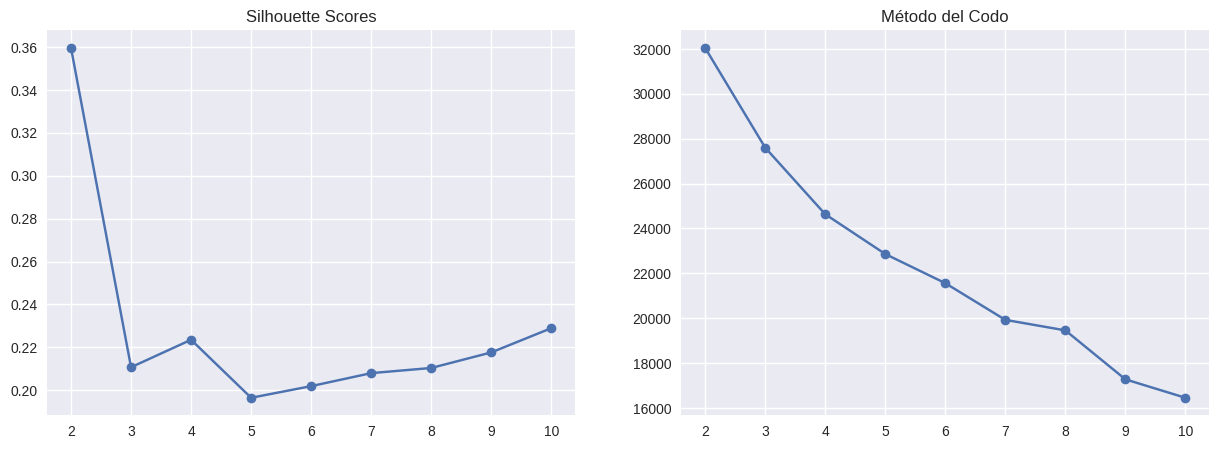

In [ ]:
# Se Busca el numero óptimo de clusters mediante KMeans
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_processed)
  sils.append(silhouette_score(X_processed, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#Método del codo y silueta
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils, marker='o')
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias, marker='o')
axes[1].set_title('Método del Codo')
axes[1].set_xticks(ks);

Dado que no se tiene coincidencia exacta con los dos metodos anteriores, se decide usar el mas aproximado que serían 4 clusters.

In [ ]:
# KMeans con 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_processed)
# Se agregan como nueva columna en el df
df['cluster'] = kmeans.labels_
df.head()

radicado num_documento  cod_segm_tasa  cod_subsegm_tasa  \
0  14427616502    1081648945              5                 2   
1  14427616257    1032058622              2                -1   
2  14427615471    1081374249              5                 2   
3  14427615471    1081374249              5                 2   
4  14427615471    1081374249              5                 2   

  cal_interna_tasa                             id_producto  \
0               C4              OEL - operacion_especifica   
1               R1  0000000000097492172 - 29-Cartera Total   
2               C4                           OEL - leasing   
3               C4              OPE - operacion_especifica   
4               C4                           RLP - cartera   

        tipo_id_producto  valor_inicial fecha_desembolso  plazo  ...  \
0    cod_plan - producto   1.050000e+06       2023-01-31   60.0  ...   
1  Obligacion - producto   2.848500e+05       2021-09-30   61.0  ...   
2    cod_plan - producto   7.528858e+04       2023-01-31   60.0  ...   
3    cod_plan - producto   5.250000e+04       2021-05-28   36.0  ...   
4    cod_plan - producto   7.500000e+04       2020-01-28   41.0  ...   

   tasa_hipotecario tasa_leasing  tasa_sufi tasa_factoring tasa_tarjeta  \
0          0.169201     0.134434   0.111939       0.150932       0.3867   
1          0.081032     0.082563   0.072089       0.128401       0.3867   
2          0.169201     0.134434   0.111939       0.150932       0.3867   
3          0.169201     0.134434   0.111939       0.150932       0.3867   
4          0.169201     0.134434   0.111939       0.150932       0.3867   

   tasa_producto tasa_efectiva  valor_inicial_te   total_deuda  cluster  
0       0.202839      0.015509      16284.872030  1.050000e+06        0  
1       0.121857      0.009628       2742.580294  2.414313e+05        0  
2       0.134434      0.010567        795.544720  3.448139e+05        0  
3       0.202839      0.015509        814.243602  3.448139e+05        0  
4       0.190215      0.014617       1096.272079  3.448139e+05        0  

[5 rows x 31 columns]

In [ ]:
# Se agrupa por cluster y la media
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

cluster  cod_segm_tasa  cod_subsegm_tasa  valor_inicial       plazo  \
0        0       4.726172          1.953101  326783.677537   38.033333   
1        1       4.804487          1.743590  369862.517052   38.403226   
2        2       4.686627          1.898204  343017.895198  543.732733   
3        3       4.583333          1.736111  225883.268609   40.569444   

   cod_periodicidad    saldo_deuda  cod_segmento  cod_subsegmento  \
0          1.329803  248961.269726      4.726172         1.953101   
1          1.201923  255342.318749      4.804487         1.743590   
2          1.231537  249785.581589      4.686627         1.898204   
3          1.638889  134862.844669      4.583333         1.736111   

   tasa_cartera  tasa_operacion_especifica  tasa_hipotecario  tasa_leasing  \
0      0.208359                   0.201886          0.143814      0.120379   
1      0.208930                   0.201859          0.147431      0.120927   
2      0.208485                   0.200920          0.145537      0.120082   
3      0.211945                   0.201262          0.144107      0.118468   

   tasa_sufi  tasa_factoring  tasa_tarjeta  tasa_producto  tasa_efectiva  \
0   0.105002        0.150373        0.3867       0.235585       0.023615   
1   0.105271        0.152232        0.3867       0.232535       0.020781   
2   0.103609        0.150413        0.3867       0.233771       0.021402   
3   0.107518        0.145527        0.3867       0.236500       0.029555   

   valor_inicial_te   total_deuda  
0       6139.441565  4.052415e+06  
1       9221.335093  4.145468e+06  
2       5874.720518  4.180878e+06  
3       5613.790018  3.508052e+06

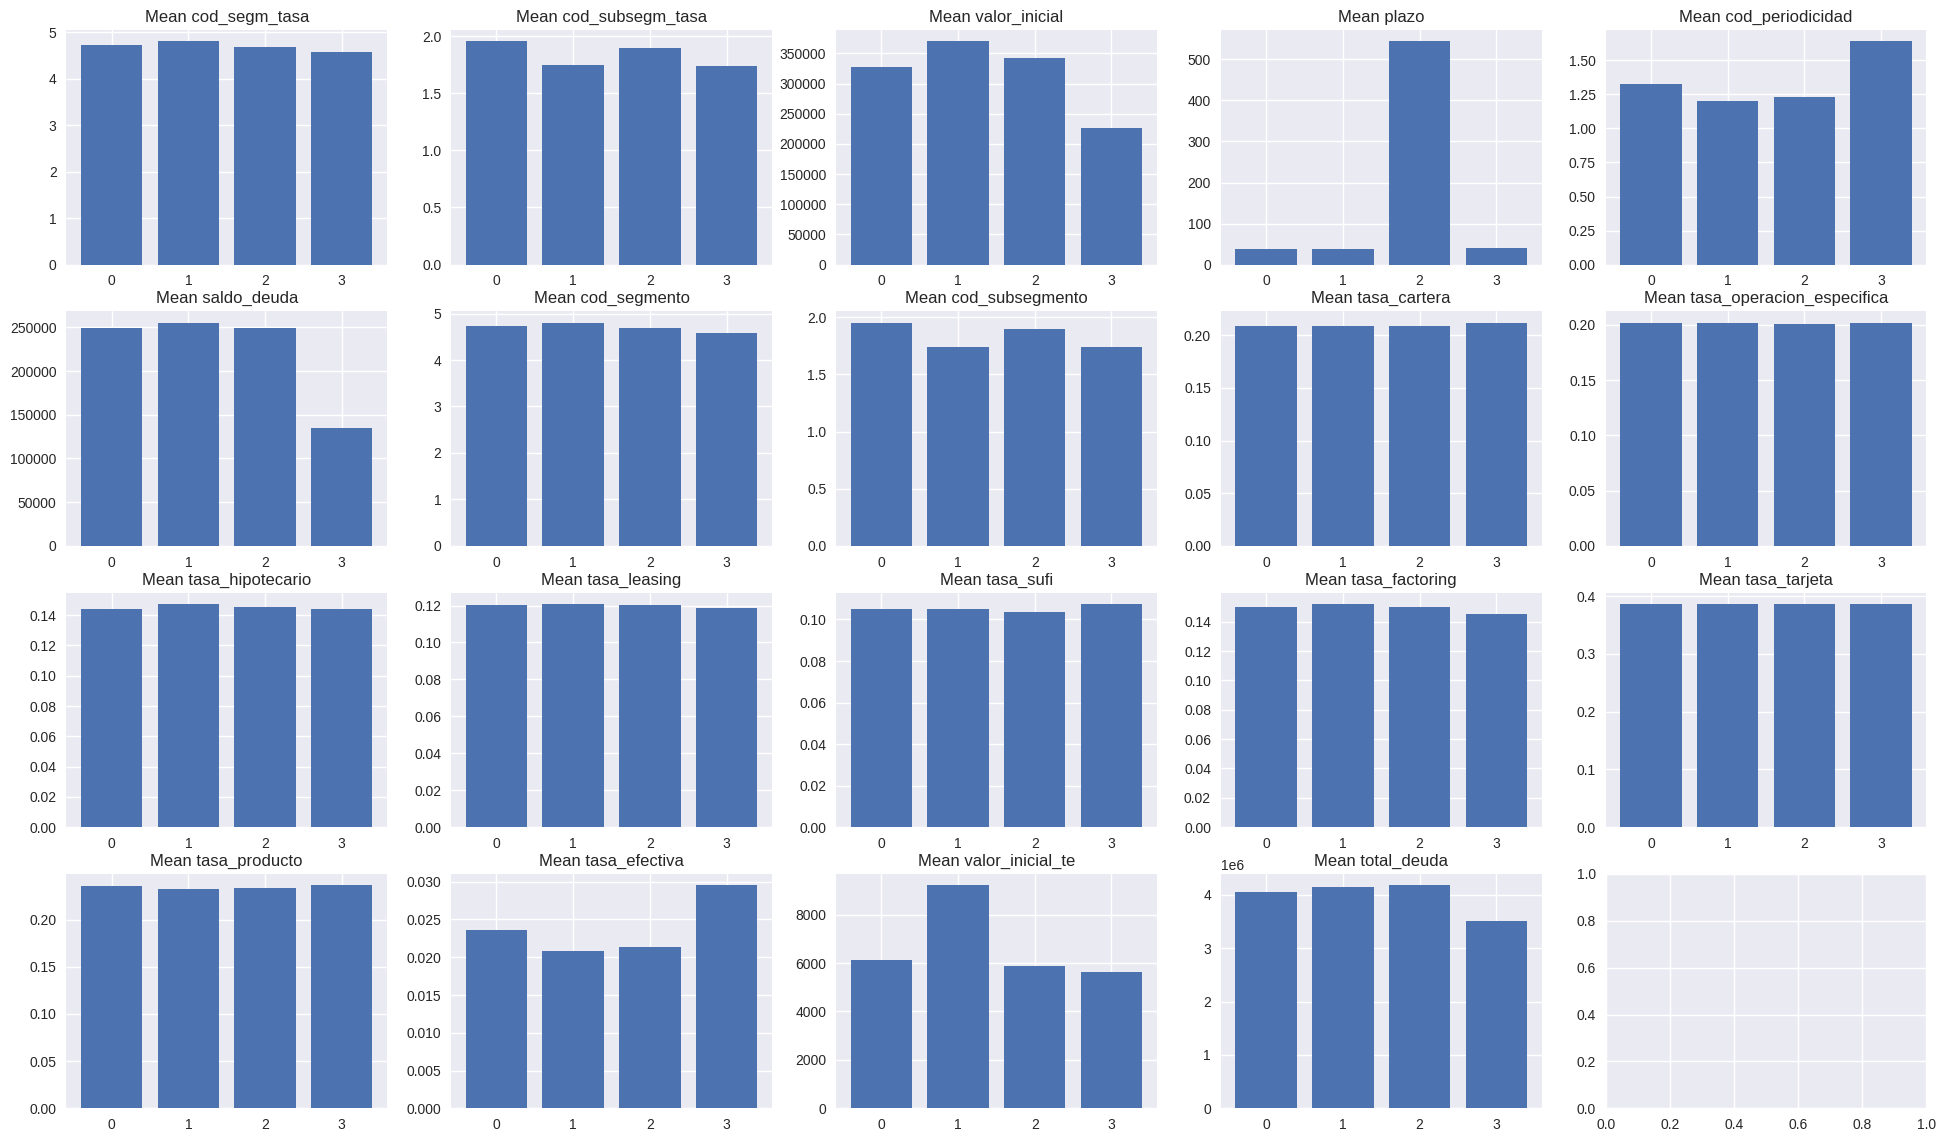

In [ ]:
# Clusters
fig, axes = plt.subplots(4,5, figsize = (24, 14))
axes = axes.ravel()

for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

**Agglomerative Cluster**

In [ ]:
#Modelos

modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X_processed)

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X_processed)

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X_processed)

AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

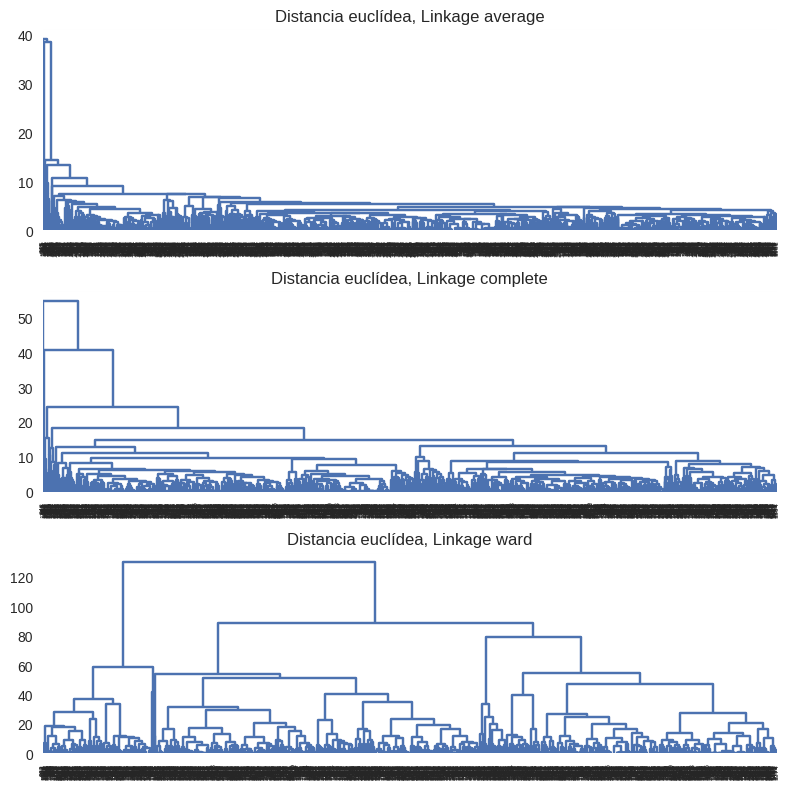

In [ ]:
#Dendrogramas

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")

plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")

plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")

plt.tight_layout();

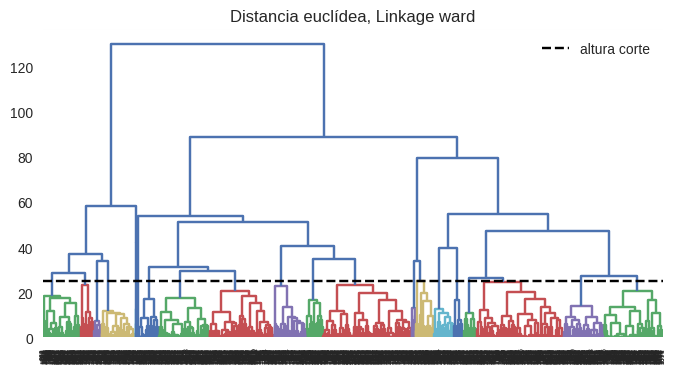

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 25

plot_dendrogram(modelo_hclust_ward, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

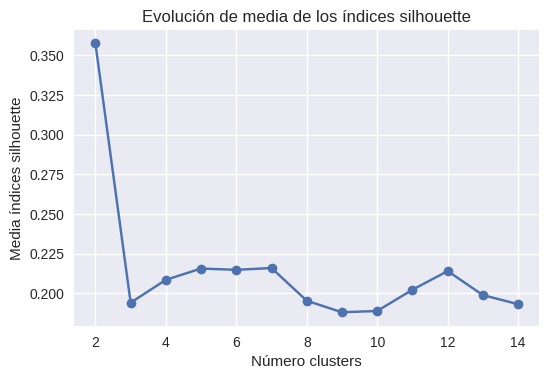

In [ ]:
# Método silhouette para identificar el número óptimo de clusters

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [ ]:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = 5
                     )
modelo_hclust_ward.fit(X_processed)

AgglomerativeClustering(affinity='euclidean', n_clusters=5)

In [ ]:
# Se agregan como nueva columna en el df
df['cluster_Agg'] = modelo_hclust_ward.labels_
df.head()

radicado num_documento  cod_segm_tasa  cod_subsegm_tasa  \
0  14427616502    1081648945              5                 2   
1  14427616257    1032058622              2                -1   
2  14427615471    1081374249              5                 2   
3  14427615471    1081374249              5                 2   
4  14427615471    1081374249              5                 2   

  cal_interna_tasa                             id_producto  \
0               C4              OEL - operacion_especifica   
1               R1  0000000000097492172 - 29-Cartera Total   
2               C4                           OEL - leasing   
3               C4              OPE - operacion_especifica   
4               C4                           RLP - cartera   

        tipo_id_producto  valor_inicial fecha_desembolso  plazo  ...  \
0    cod_plan - producto   1.050000e+06       2023-01-31   60.0  ...   
1  Obligacion - producto   2.848500e+05       2021-09-30   61.0  ...   
2    cod_plan - producto   7.528858e+04       2023-01-31   60.0  ...   
3    cod_plan - producto   5.250000e+04       2021-05-28   36.0  ...   
4    cod_plan - producto   7.500000e+04       2020-01-28   41.0  ...   

   tasa_leasing tasa_sufi  tasa_factoring tasa_tarjeta tasa_producto  \
0      0.134434  0.111939        0.150932       0.3867      0.202839   
1      0.082563  0.072089        0.128401       0.3867      0.121857   
2      0.134434  0.111939        0.150932       0.3867      0.134434   
3      0.134434  0.111939        0.150932       0.3867      0.202839   
4      0.134434  0.111939        0.150932       0.3867      0.190215   

   tasa_efectiva valor_inicial_te   total_deuda cluster  cluster_Agg  
0       0.015509     16284.872030  1.050000e+06       0            2  
1       0.009628      2742.580294  2.414313e+05       0            2  
2       0.010567       795.544720  3.448139e+05       0            2  
3       0.015509       814.243602  3.448139e+05       0            2  
4       0.014617      1096.272079  3.448139e+05       0            2  

[5 rows x 32 columns]

In [ ]:
# Se agrupa por cluster y la media
cluster_Agg = df.groupby('cluster_Agg', as_index=False).mean()
cluster_Agg

cluster_Agg  cod_segm_tasa  cod_subsegm_tasa  valor_inicial       plazo  \
0            0       4.694040          1.862252  362547.289954  705.468792   
1            1       5.250000          0.625000  342207.750000   60.625000   
2            2       4.708287          1.966851  315706.892734   41.002215   
3            3       4.635135          1.851351  214417.518106   39.243243   
4            4       4.783607          1.750820  371561.122362   37.904290   

   cod_periodicidad    saldo_deuda  cod_segmento  cod_subsegmento  \
0          1.276821  269503.645628      4.694040         1.862252   
1          1.000000  169210.462280      5.250000         0.625000   
2          1.266298  233284.032698      4.708287         1.966851   
3          1.621622  136303.186705      4.635135         1.851351   
4          1.206557  256354.290989      4.783607         1.750820   

   tasa_cartera  ...  tasa_hipotecario  tasa_leasing  tasa_sufi  \
0      0.208828  ...          0.144537      0.120062   0.103891   
1      0.203261  ...          0.147294      0.121140   0.111288   
2      0.208031  ...          0.145152      0.120323   0.104343   
3      0.212149  ...          0.142236      0.117997   0.107351   
4      0.209230  ...          0.147777      0.121021   0.105266   

   tasa_factoring  tasa_tarjeta  tasa_producto  tasa_efectiva  \
0        0.150878        0.3867       0.235647       0.022290   
1        0.165605        0.3867       0.229816       0.017246   
2        0.149993        0.3867       0.233296       0.022275   
3        0.145911        0.3867       0.235686       0.029183   
4        0.151823        0.3867       0.233485       0.020921   

   valor_inicial_te   total_deuda   cluster  
0       6287.271605  4.218485e+06  1.962914  
1       4245.037318  3.676887e+06  0.875000  
2       5736.912116  4.065754e+06  0.576796  
3       5458.019636  3.246440e+06  2.918919  
4       9341.773721  4.195859e+06  1.000000  

[5 rows x 21 columns]

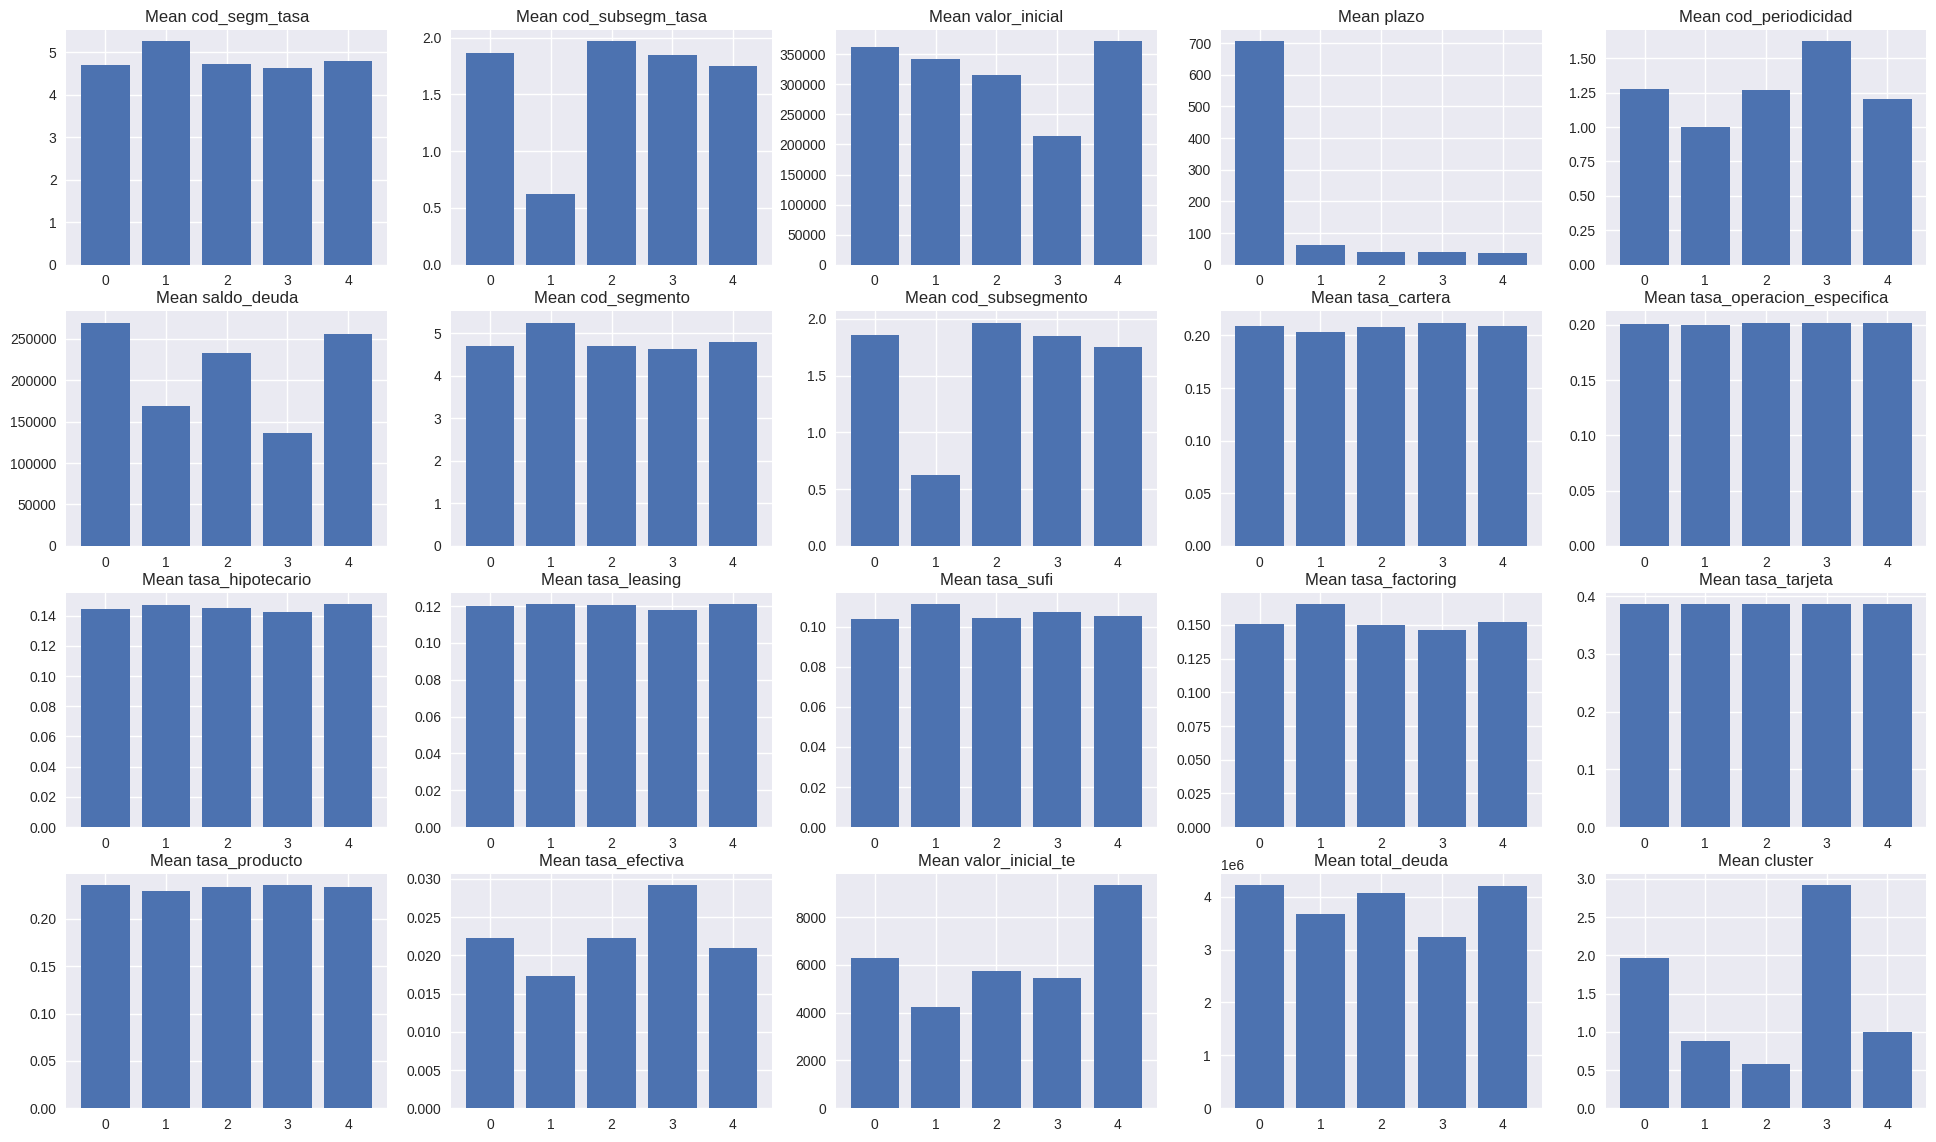

In [ ]:
# Clusters
fig, axes = plt.subplots(4,5, figsize = (24, 14))
axes = axes.ravel()

for i, col in enumerate(cluster_Agg.columns[1:]):
  axes[i].bar(cluster_Agg['cluster_Agg'], cluster_Agg[col])
  axes[i].set_title(f'Mean {col}')

**Regresión Lineal**

In [ ]:
#Instanciar modelo regresión lineal
reg = LinearRegression()

#Ajustar modelo
reg.fit(X_train_processed,y_train)

# Predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train_processed)
# Predicciones del conjunto de prueba
test_preds = reg.predict(X_test_processed)

#Medición del rendimiento del modelo
train_score = reg.score(X_train_processed, y_train)
test_score = reg.score(X_test_processed, y_test)

print(train_score, '\n')

print(test_score)

0.8165764367286091 

0.8679627590734739


**Bagged trees**

In [ ]:
# Definición de parámetros
n_estimators=[20,40,60,100,120,150,180,200]

parameters = {'n_estimators':n_estimators}

#Instanciar modelo
bagreg = BaggingRegressor(random_state = 42)

BG= GridSearchCV(estimator=bagreg, param_grid = parameters, scoring='r2',return_train_score=True)

In [ ]:
#Entrenar modelo
BG.fit(X_train_processed, y_train)

GridSearchCV(estimator=BaggingRegressor(random_state=42),
             param_grid={'n_estimators': [20, 40, 60, 100, 120, 150, 180, 200]},
             return_train_score=True, scoring='r2')

In [ ]:
#Hiperparámetros ideales
print(BG.best_params_)
print("r2 "+str(BG.best_score_))

{'n_estimators': 100}
r2 0.5365005643233888


In [ ]:
# Resultados
resultados_BG = pd.DataFrame(BG.cv_results_)
resultados_BG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

param_n_estimators  mean_test_score  std_test_score  mean_train_score  \
3                100         0.536501        0.575863          0.955611   
6                180         0.535291        0.567159          0.953670   
5                150         0.534636        0.571960          0.955698   
4                120         0.533980        0.578357          0.956424   
7                200         0.533270        0.575865          0.953755   
2                 60         0.506772        0.610110          0.958388   
0                 20         0.502743        0.595537          0.959626   
1                 40         0.481728        0.646855          0.957783   

   std_train_score  
3         0.009619  
6         0.009674  
5         0.009317  
4         0.008797  
7         0.010090  
2         0.009481  
0         0.006811  
1         0.010138

In [ ]:
#Mejor modelo de Baggin
model_1 = BaggingRegressor(random_state=42, n_estimators=100)
model_1.fit(X_train_processed, y_train)

#Predicción de valores
y_b_predict= model_1.predict(X_test_processed)

In [ ]:
#Rendimiento de modelo
train_preds_B= model_1.predict(X_train_processed)
test_preds_B= model_1.predict(X_test_processed)

r2_train_B = r2_score(y_train, train_preds_B)
r2_test_B = r2_score(y_test, test_preds_B)

rmse_train_B = np.sqrt(mean_squared_error(y_train, train_preds_B))
rmse_test_B = np.sqrt(mean_squared_error(y_test, test_preds_B))

print("Árbol de regresión")
print("R2")
print(r2_train_B)
print(r2_test_B, '\n')

print("RMSE")
print(rmse_train_B)
print(rmse_test_B)

Árbol de regresión
R2
0.9537134496375574
0.794383985001891 

RMSE
137801.81957616017
322874.5634163304


**Regresión de bosque aleatorio**

In [ ]:
# Definición de parámetros
n_estimators=[20,40,60,100,120,150,180,200]
max_depth=[4,8,12,14,18,20]

parameters_2 = {'n_estimators':n_estimators,'max_depth':max_depth}

#Instanciar modelo
RF = RandomForestRegressor(random_state = 42)

RFG= GridSearchCV(estimator=RF, param_grid = parameters_2, scoring='r2',return_train_score=True)

In [ ]:
#Entrenar modelo
RFG.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 8, 12, 14, 18, 20],
                         'n_estimators': [20, 40, 60, 100, 120, 150, 180, 200]},
             return_train_score=True, scoring='r2')

In [ ]:
#Hiperparámetros ideales
print(RFG.best_params_)
print("r2 "+str(RFG.best_score_))

{'max_depth': 14, 'n_estimators': 100}
r2 0.537865968290163


In [ ]:
# Resultados
resultados_RFG = pd.DataFrame(RFG.cv_results_)
resultados_RFG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

param_max_depth param_n_estimators  mean_test_score  std_test_score  \
27              14                100         0.537866        0.556457   
14               8                180         0.534887        0.565821   
11               8                100         0.532270        0.572183   
12               8                120         0.528463        0.578900   
35              18                100         0.528180        0.579503   
13               8                150         0.528072        0.575890   
15               8                200         0.527964        0.581085   
30              14                180         0.527339        0.579423   
29              14                150         0.526089        0.580915   
31              14                200         0.523898        0.587898   
28              14                120         0.521918        0.583145   
37              18                150         0.519906        0.585577   
36              18                120         0.519859        0.587842   
38              18                180         0.516645        0.590058   
39              18                200         0.515781        0.598219   
26              14                 60         0.515621        0.576564   
23              12                200         0.515365        0.593674   
22              12                180         0.510612        0.600332   
34              18                 60         0.501826        0.602547   
19              12                100         0.501524        0.616007   
25              14                 40         0.500805        0.597339   
47              20                200         0.500483        0.631667   
46              20                180         0.498590        0.632567   
21              12                150         0.497372        0.623073   
6                4                180         0.496595        0.601514   
20              12                120         0.494578        0.633422   
7                4                200         0.491481        0.615337   
45              20                150         0.490717        0.651294   
33              18                 40         0.489104        0.637306   
5                4                150         0.484521        0.630823   
43              20                100         0.480551        0.667015   
3                4                100         0.479426        0.629211   
10               8                 60         0.478507        0.626455   
4                4                120         0.477143        0.639642   
44              20                120         0.475691        0.681737   
9                8                 40         0.461497        0.656861   
32              18                 20         0.440474        0.736812   
18              12                 60         0.440384        0.683841   
2                4                 60         0.439213        0.663691   
17              12                 40         0.438833        0.670856   
1                4                 40         0.437233        0.665304   
24              14                 20         0.434867        0.689889   
42              20                 60         0.421829        0.748598   
8                8                 20         0.394162        0.744047   
41              20                 40         0.393075        0.799783   
0                4                 20         0.362551        0.774030   
16              12                 20         0.350367        0.797540   
40              20                 20         0.305828        0.929677   

    mean_train_score  std_train_score  
27          0.954252         0.011223  
14          0.951014         0.010995  
11          0.951949         0.011938  
12          0.953175         0.010528  
35          0.955679         0.009419  
13          0.952802         0.010752  
15          0.951031         0.011527  
30          0.952581         0.011109  
29          0.95

In [ ]:
#Mejor modelo de Random Forest
model_2 = RandomForestRegressor(random_state=42, max_depth=14, n_estimators=100)
model_2.fit(X_train_processed, y_train)

RandomForestRegressor(max_depth=14, random_state=42)

In [ ]:
#Predicción de valores
y_RF_predict= model_2.predict(X_test_processed)

y_RF_predict = pd.DataFrame(y_RF_predict)

In [ ]:
#Rendimiento de modelo
train_preds_AR2= model_2.predict(X_train_processed)
test_preds_AR2= model_2.predict(X_test_processed)

r2_train_AR = r2_score(y_train, train_preds_AR2)
r2_test_AR = r2_score(y_test, test_preds_AR2)

rmse_train_AR = np.sqrt(mean_squared_error(y_train, train_preds_AR2))
rmse_test_AR = np.sqrt(mean_squared_error(y_test, test_preds_AR2))

print("Árbol de regresión")
print("R2")
print(r2_train_AR)
print(r2_test_AR, '\n')

print("RMSE")
print(rmse_train_AR)
print(rmse_test_AR)

Árbol de regresión
R2
0.954334043024152
0.8023025391059775 

RMSE
136874.9035846312
316596.3537301408


In [ ]:
df['prediccion_saldo_deuda']=y_RF_predict

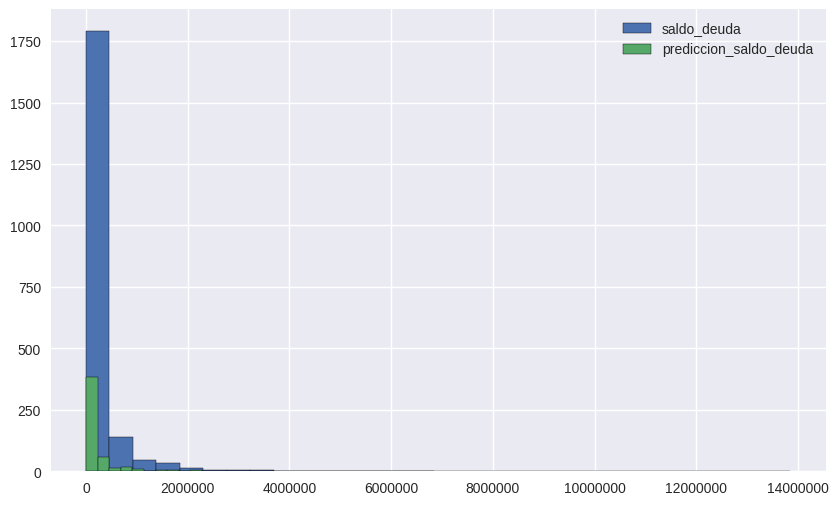

In [ ]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn')
df['saldo_deuda'].hist(bins = 30,edgecolor='black',label='saldo_deuda')
df['prediccion_saldo_deuda'].hist(bins = 30,edgecolor='black',label='prediccion_saldo_deuda')
plt.ticklabel_format(useOffset=False, style='plain')
plt.legend(loc='upper right')
plt.show()

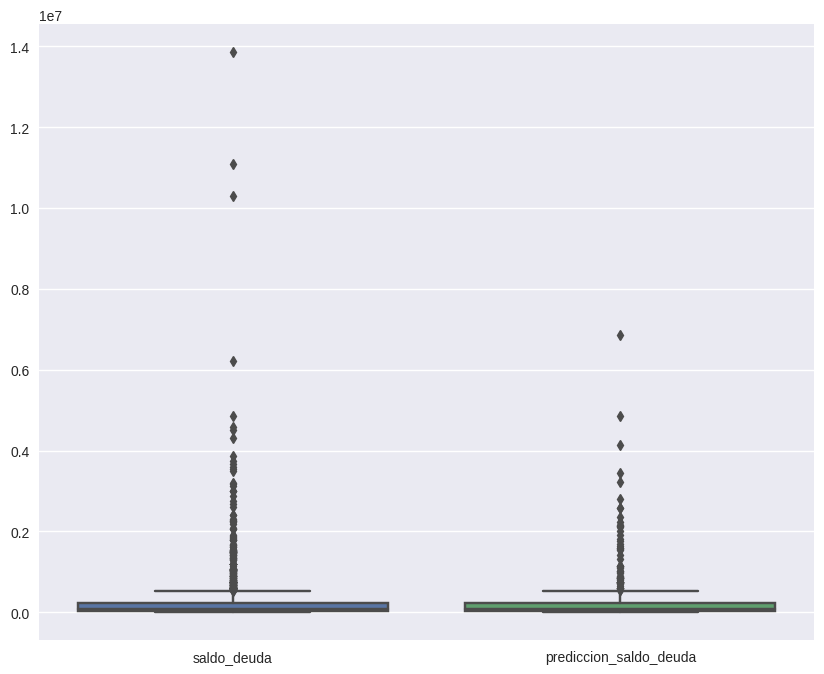

In [ ]:
#Se generan gráficos boxplot por grupos de variables
df_plot1= df[['saldo_deuda', 'prediccion_saldo_deuda']]
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_plot1)
plt.show()